# K-Nearest Neighbours #

$\textit{Xavier Gasper}$

## Contents ##
1. Introduction
2. Preliminary code
3. Overview of how KNN works
4. Choosing a metric
5. Choosing a value of k
6. Using KNN on the iris dataset
7. Advantages & Disadvantages of using KNN

## Introduction ##
**KNN** is a supervised machine learning model that works on a principle of similarity: a target is presumed to be similar to its nearest neighbouring datapoints, so features from its nearest neighbours are used to make a prediction about the target.

It is typically used to solve problems in
- **classification**: a class label is chosen by majority vote by the k-nearest neighbours of the target
- **regression**: a target data point is assigned the mean of the average values of a feature of its k-nearest neighbours

I will focus predominantly on the use of KNN for solving classification problems.

## Preliminary code ##

I will first include some neccessary code that will be implemented and used throughout the rest of this section:

In [1]:
# Importing required libraries for this chapter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
# Choosing a seed for reproduciablity
np.random.seed(13) 

In [3]:
def load_circular_dataset(N):
    """
    Arguments:
    N -- integer, number of datapoints to be generated
    
    Returns:
    datapoints -- 2-dimensional numpy array of size 2 * N, where each element represents an x-y coordinate of a datapoint
    labels -- 1-dimensional numpy array of size N, where each element corresponds to a class label for a point (either 0 or 1)
    """    
    
    # Initalises an array containing n random coordinates, and an array of labels containing n zeroes
    datapoints = np.random.random((N,2))*20-10
    labels = np.zeros(N)
    
    # Radius of circle
    r = 7
    
    # Inspects each of the randomly generated datapoints, and relabels them to 1 if they lie within the circle
    for i in range(len(datapoints)):
        if datapoints[i,0]**2 + datapoints[i,1]**2 < r**2:
            labels[i] = 1
            
    return datapoints, labels

In [4]:
def generate_point_within_circle(centre_x, centre_y, r):
    """
    Arguments:
    centre_x -- float, x-coordinate of the centre of the circle
    centre_y -- float, y-coordinate of the centre of the circle
    r -- float, radius of circle
    
    Returns:
    x -- float, x-coordinate of a random point within the circle
    y -- float, y-coordinate of a random point within the circle
    """    
    
    # Random angle
    theta = 2*np.pi*np.random.random()
    # Random radial distance
    radial_distance = r*np.random.random()
    
    # Generates x,y coordinates of a point at a random angle, and a random radial distance from the centre of a circle
    x = radial_distance*np.cos(theta) + centre_x
    y = radial_distance*np.sin(theta) + centre_y
    
    return x,y


def load_two_circular_clusters(N):
    """
    Arguments:
    N -- integer, number of datapoints to be generated in a single circle - total number of datapoints = 2N
    
    Returns:
    datapoints -- 2-dimensional numpy array of size 2 * 2N, where each element represents an x-y coordinate of a datapoint
    labels -- 1-dimensional numpy array of size 2N, where each element corresponds to a class label for a point (either 0 or 1)
    """    
    
    # Initalises arrays to hold coordinates of datapoints belonging to each circle
    datapoints_0 = np.zeros((N,2))
    datapoints_1 = np.zeros((N,2))

    # Generates labels to be applied to each point within each circle
    labels_0 = np.zeros(N)
    labels_1 = np.zeros(N) + 1
    
    # Replaces each element within datapoints_0 and datapoints_1 with coordinates of points within each circle
    for elem in datapoints_0:
        elem[0], elem[1] = generate_point_within_circle(0,0,1)
        # Circle of radius 1, centred at the origin
    
    for elem in datapoints_1:
        elem[0], elem[1] = generate_point_within_circle(3,0,1)
        # Circle of radiius 1, centred at (3,0)
    
    datapoints = np.concatenate((datapoints_0, datapoints_1))
    labels = np.concatenate((labels_0, labels_1))
    
    return datapoints, labels

In [5]:
def plot_decision_boundary(clf, datapoints, labels):
    """
    Arguments:
    clf -- object, trained KNN model fitted on the given dataset and its associated labels 
    datapoints -- 2-dimensional numpy array where each element represents an x-y coordinate of a datapoint
    labels -- 1-dimensional numpy array, where each element corresponds to a class label for a point (either 0 or 1)
    x_lim -- tuple, containing upper & lower bounds for x-axis of plot
    y_lim -- tuple, containing upper & lower bounds for y-axis of plot
    
    Returns:
    A plot of the datapoints with corresponding decision boundaries  
    """
    
    _, ax = plt.subplots()
    
    # Uses SKlearn's DecisionBoundaryDisplay to generate and colour decision boundaries for the KNN model
    DecisionBoundaryDisplay.from_estimator(clf,
                                       datapoints,
                                       ax=ax,
                                       grid_resolution=500,
                                       response_method="predict",
                                       plot_method="pcolormesh",
                                       xlabel="X",
                                       ylabel="Y",
                                       alpha=0.3
                                          )
    
    # intialises scatter plot of decision boundaries and dataset
    ax.scatter(datapoints[:,0], datapoints[:,1], c=labels, s=40, cmap="winter", edgecolors="k")

## Overview of how KNN works ##
In order to classify a target KNN requires **3** things:
1. a **dataset**
2. a **metric**
3. _**k**_, an integer representing the number of nearest neighbours

I will explore further later on how we choose a metric or specific value of k for our model.

To classify a target:
1. The distance between a target and all other points is calculated
2. The _k_ closest data points to the target are identified
3. The mode class label amongst the target's _k_ nearest neighbours is assigned

For our dataset, we will use:

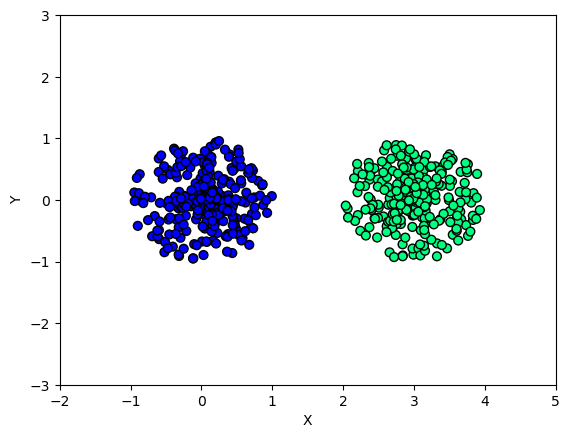

In [6]:
# Loads in a dataset using the previously defined function
datapoints, labels = load_two_circular_clusters(300)

plt.scatter(datapoints[:,0], datapoints[:,1], c=labels, s=40, edgecolors="k", cmap="winter")
plt.xlim(-2,5)
plt.ylim(-3,3)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

For our metric we choose Euclidean distance:

In [7]:
def euclidean_distance(p, P):
    """
    Arguments:
    p -- 1-dimensional numpy array of size 1*2, representing the coordinates of a point
    P -- 1-dimensional numpy array of size 1*2, representing the coordinates of another point
    
    Returns:
    distance -- float, the euclidean distance between p and P
    """   
    
    distance = np.sqrt((p[0]-P[0])**2 + (p[1]-P[1])**2)
    
    return distance

Given a random unidentiifed red datapoint, we can use KNN to identify whether or not it should belong to the blue or green cluster. 

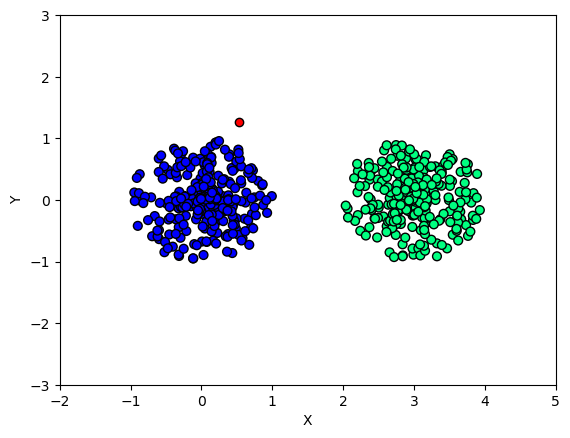

In [8]:
# Random unidentified datapoint
p = np.random.rand(2)*2

plt.scatter(datapoints[:,0], datapoints[:,1], c=labels, s=40, edgecolors="k", cmap="winter")
plt.scatter(p[0], p[1], color="red", edgecolors="k")
plt.xlim(-2,5)
plt.ylim(-3,3)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

We use the algorithm previously described to produce a function that is able to classify the point:

In [9]:
def classification_of_point(dataset, test_point, k):
    """
    Arguments:
    dataset -- 2-dimensional numpy array where each element represents an x-y coordinate of a point
    test_point -- 1-dimensional numpy array containing the x-y coordinates of an unclassified point 
    k -- integer, the number of nearest neighbours we will be comparing the unclassified point to
    
    Returns:
    classification -- integer, a class label either 0 or 1
    """
    
    # An empty list to store the distance and index of each point from the test_point
    distances = []
    
    # Calculates the distance between the test_point and all other points
    for i in range(len(dataset)):
        dist = euclidean_distance(test_point,dataset[i])
        distances.append((dist,i))
    
    # Chooses the k-nearest neighbours
    closest_k_points = (sorted(distances))[:k]
    
    # Tallies the number of each class appearing in the k-nearest neighbours
    frequencies = [0,0]
    for elem in closest_k_points:
        frequencies[int(labels[elem[1]])] += 1
    
    # The class label assigned to test_point is the mode class label amongst its k-nearest neighbours 
    classification = pd.Series(frequencies).idxmax()

    return classification 

Using this KNN model to identify the red, unlabelled datapoint, we clearly see it is correctly relabelled in accordance to the cluster it is closest with:

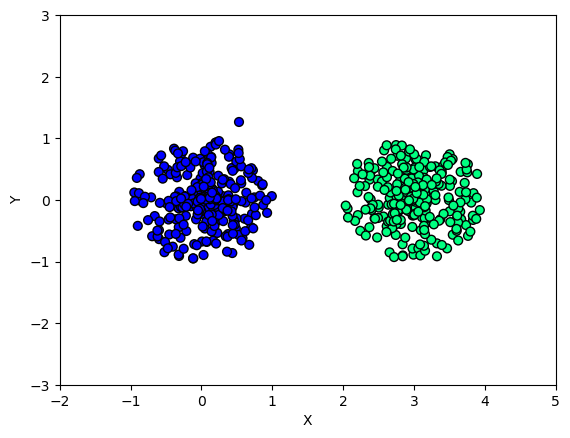

In [10]:
# Relabels the unidentified datapoint using a KNN model with k=5, before adding the unidentified point to the dataset
new_value = classification_of_point(datapoints, p, 5)
datapoints = np.concatenate((datapoints,np.array([p])))
labels = np.concatenate((labels,np.array([new_value])))

# Plots the dataset for a final time, with the previously unidentified datapoint relabelled and recoloured
plt.scatter(datapoints[:,0], datapoints[:,1], c=labels, s=40, edgecolors="k", cmap="winter")
plt.xlim(-2,5)
plt.ylim(-3,3)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

From now on, I will be using SciKit Learn when coding examples involving KNN and make use of the in-built DecisionBoundaryDisplay function.

## Choosing a metric ##
Given the reliance of KNN on distance, the metric we choose is incredibly important and specific to a given dataset. Most commonly we use:
- **Euclidean distance**: this can be thought of as the straight line distance between any two points in $\mathbb{R}^3$
$$d(x,y) = \sqrt{\sum\limits_{i=1}^{n}(x_i-y_i)^2}$$
- **Manhattan distance**: also known as taxicab distance
$$d(x,y) = \sum\limits_{i=1}^{n}|x_i-y_i|$$

These are both generalisations of a broader notion of distance known as **Minkowski distance** for **p = 1** and **p = 2**:

$$d(x,y) = (\sum\limits_{i=1}^{n}|x_i-y_i|^p)^{1/p}$$

When an incorrect metric is used, the KNN model breaksdown (as evidenced below) when we compare the decision boundaries generated when **Euclidean** and **Manhattan** distance are used compared to **Cosine** and **Haversine** distance, two other metrics in-built to SciKit Learn.

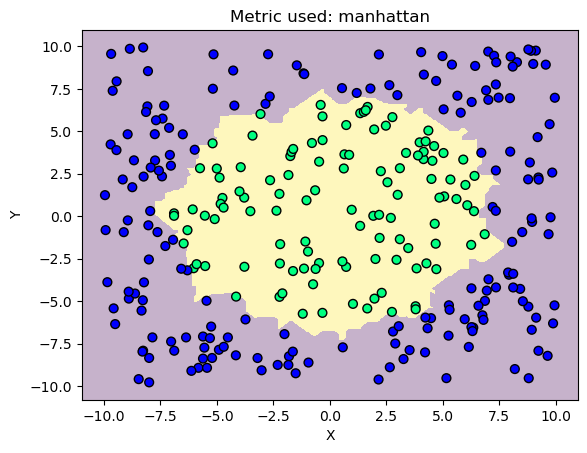

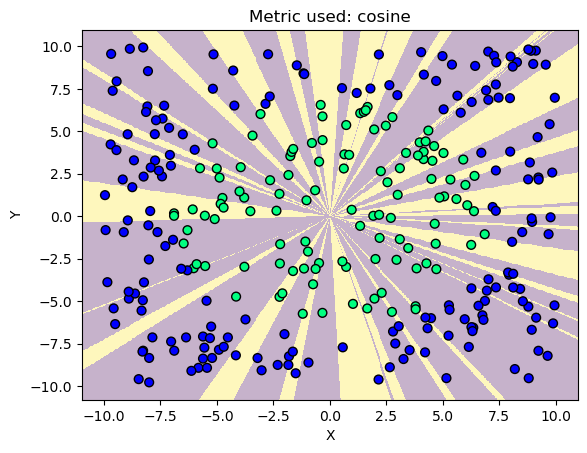

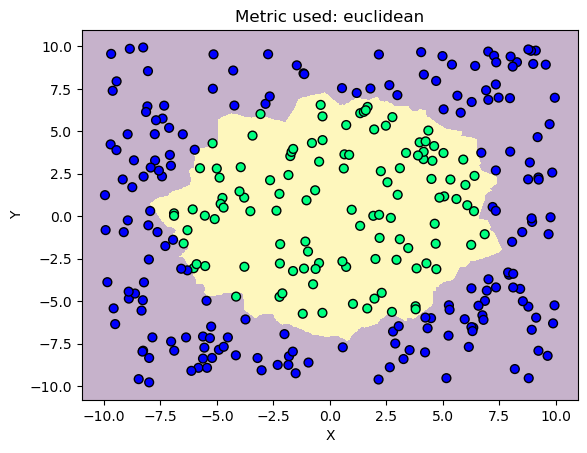

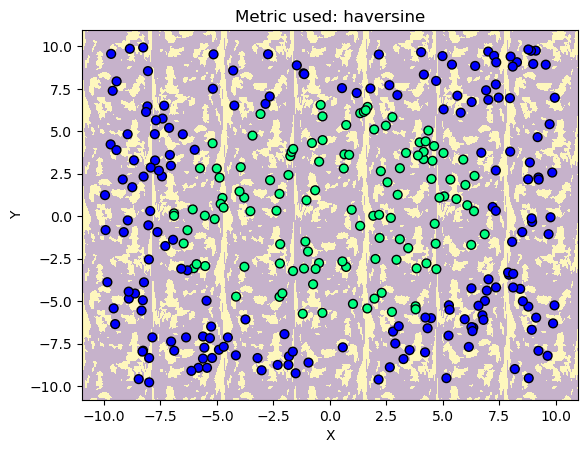

In [11]:
datapoints, labels = load_circular_dataset(300)

possible_metrics = ["manhattan","cosine","euclidean","haversine"]

# Produces a plot for each choice of metric 
for m in possible_metrics:
    knn = KNeighborsClassifier(n_neighbors=3,metric=m,algorithm="auto").fit(datapoints, labels)
    plot_decision_boundary(knn,datapoints,labels)
    plt.title("Metric used: "+m)
    
    plt.show()
    
# BEWARE running this cell can take up to 1 min for the output to complete

As evidenced, the decision boundaries are fairly similar when **Manhattan** and **Euclidean** distance were used, however the model completely brokedown and gave meaningless decision boundaries for **Cosine** and **Haversine** distance as they are metrics for different datasets.

## Choosing a value of k ##
The choice of _k_ depends on the **number of features** of each datapoint and the **number of members of each class.**

Generally:
- as **_k_ increases** the accuracy of the model will improve and the model becomes less prone to overfitting
- _However_, beyond a certain value, as k approaches the **total number of points** in the dataset, the accuracy of the model decreases and the class with the great number of members will become overrepresented 

Typically _k_ is chosen after the model is run several times with different choices of integers and one is settled on that correctly identifies the most points.

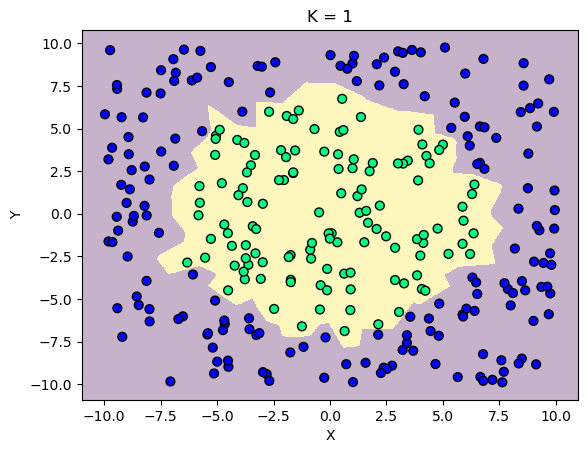

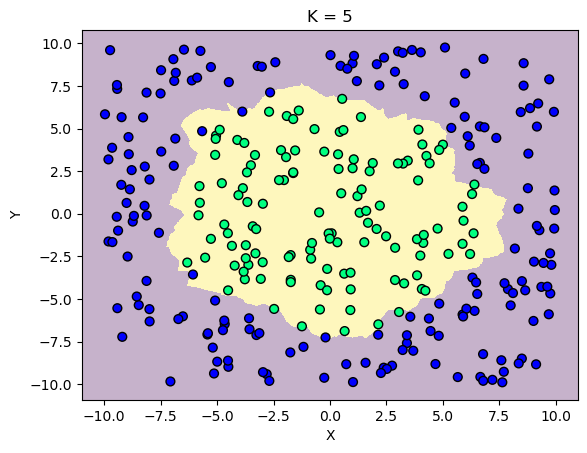

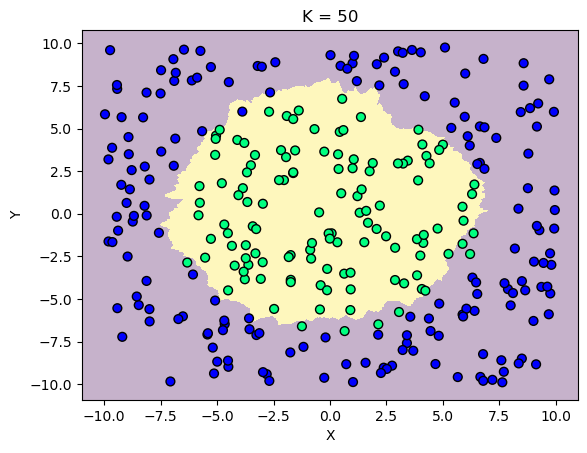

In [ ]:
datapoints, labels = load_circular_dataset(300)

k_values = [1,5,50,125,250] 

# Produces a plot for various values of K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm="auto").fit(datapoints, labels)
    plot_decision_boundary(knn,datapoints,labels)
    plt.title("K = "+str(k))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# BEWARE running this cell can take up to 2 min for the output to complete

As depicted as _k_ tended to 300, the dominant class of blue points becomes becomes overrepresented. 

## Using KNN on iris dataset ##

Thus far, I have been using KNN only on abstract, visual datasets. I will code a perform a test-train split on the iris dataset and use KNN to identify flower species from petal length and petal width: 

In [ ]:
# loads in the iris dataset and assigns titles to the values in each column, and shuffles the dataset
column_titles = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv('iris.data', names = column_titles).sample(n=150)

# Extracts the corresponding species of each flower in the dataset
# Uses LabelEncoder() to associate each species with a number between 0 and 2 inclusive 
flower_type_og = iris["species"].values
flower_type = LabelEncoder().fit_transform(flower_type_og)

# Extracts the petal length and petal width of each flower, and labels them with the number corresponding to their species
datapoints = iris.iloc[:,2:4].values
labels = flower_type

# Test-train split, reserving the final 10 flowers in the dataset of testing
X_train = datapoints[:-10]
X_test = datapoints[-10:]
Y_train = labels[:-10]
Y_test = labels[-10:]

# Plots the iris dataset, with the unidentified flowers in red 
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="winter")
plt.scatter(X_test[:,0], X_test[:,1], color = "red", edgecolor="k")
plt.title("Iris dataset with unidentified flowers")
plt.xlabel("Petal length in cm")
plt.ylabel("Petal width in cm")
plt.show()

# Fitting KNN model to the training dataset & plotting decision boundaries
knn = KNeighborsClassifier(n_neighbors=5,algorithm="auto").fit(X_train, Y_train)
plot_decision_boundary(knn,X_train,Y_train)
plt.title("Decision boundaries generated by KNN on iris dataset")
plt.xlabel("Petal length in cm")
plt.ylabel("Petal width in cm")
plt.show()

# Using KNN to label the unidentified flowers
Y_pred = np.zeros(10)

for i in range(len(X_test)):
    Y_pred[i] = knn.predict([X_test[i]])


new_labels = np.concatenate((Y_train, Y_test))

# Plotting the output of the model
plt.scatter(datapoints[:,0], datapoints[:,1], c=new_labels)
plt.title("Iris dataset with relabelled flowers")
plt.xlabel("Petal length in cm")
plt.ylabel("Petal width in cm")
plt.show()

#Calculating the percentage of flowers correclty identified by the model
count = 0
proportion = 0

for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test[i]:
        count += 1
        proportion = count/len(Y_test)
        

print("Percentage of flowers correctly identified: "+str(proportion*100)+"%")

## Advantages & disadvantages of using KNN ##

### Advantages ###
- intuitive algorithm; **easy to code** and understand

### Disadvantages ###
- **pre-processing** of data - the reliance of KNN on distance means features have to be normalised to ensure distance comparisons are meaningful
- **significantly longer on larger datasets** as the distances between many datapoints has to be calculated
- suffers from the **curse of dimensionality** - as the number of features increases for each datapoint small distances become reduced and less meaningful
- **incorrect choice of k** can hamper the effectiveness of a model